In [3]:
from tqdm import tqdm
import datetime
tqdm.pandas()

import pandas as pd
import numpy as np
#connect local PATH
from matplotlib import pyplot as plt

import os 
import sys
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
from CryptoSent.tools.utils import load_submissions

from sklearn.preprocessing import MinMaxScaler

def errors(x,Y):
    return [Y[i]-x[i] for i in range(len(x))]

def abolute_errors(x,Y):
    return [abs(Y[i]-x[i]) for i in range(len(x))]

    
def mean_error(x,Y):
    return np.mean([Y[i]-x[i] for i in range(len(x))])

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score  
from sklearn.metrics import mean_squared_error as mse   #squared=False:rmse
#from sklearn.metrics import mean_squared_log_error as msle      #squared=False:rmsle

from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.linear_model import TweedieRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import itertools

evaluation_metrics=[mean_error,mae,mape,mse,r2_score]
evaluation_metrics_names=['me','mae','mape','mse','r2_score','rmse']
def evaluate_pred(x,Y,model_name='m1'):
    scores=[]
    for metric in evaluation_metrics:
        scores.append(metric(x,Y))
    scores.append(mse(x,Y,squared=False))
    output=pd.DataFrame(
        np.array(scores),
        index=evaluation_metrics_names,
        columns=[model_name])
    return output



# import datasets
#subs=load_submissions()
btc=get_btc_actual_hourly().sort_index()
btc['perc']=btc.close.pct_change()
btc['difference']=btc.close.diff()
#btc=btc[['close','perc','difference']]
btc=btc.dropna()



#bc=pd.read_pickle("../Datasets/Main Dataset/bitcoin_comments.pickle")
subs=pd.read_pickle("../../Datasets/Main Dataset/bitcoin_submissions.pickle")
subs['volume']=1
#bc['buy']=bc.body_clean.str.contains('buy',case=False)
#bc['sell']=bc.body_clean.str.contains('sell',case=False)
#bc['volume']=1

btc_raw=get_btc_actual_hourly()

# Baseline - Moving Average

                    m1
me       -6.480594e+01
mae       1.263619e+03
mape      3.504103e-02
mse       2.372763e+06
r2_score  2.528556e-01
rmse      1.540377e+03


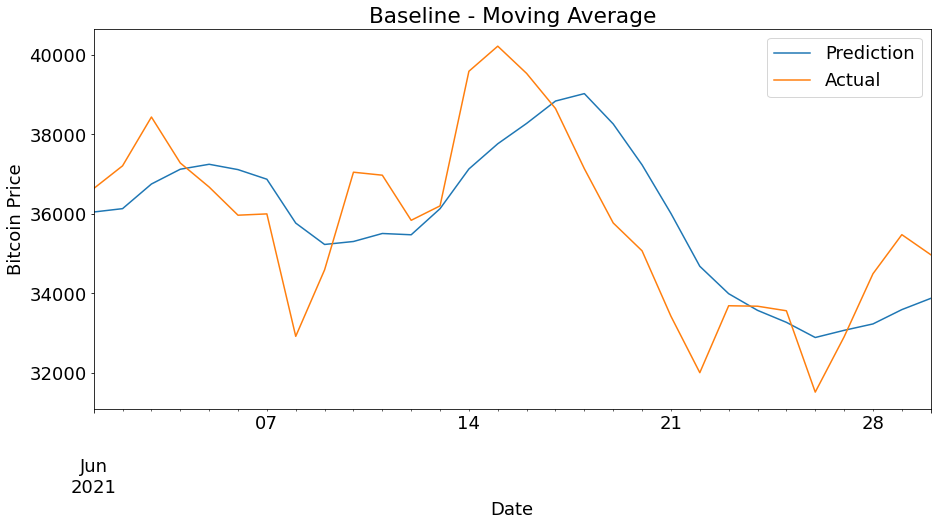

In [844]:
dstart='2021-06-1'
dend='2021-06-30'
rolling_window=5
resample_period='d'
feature='close'# close, difference, perc

x=btc_raw[feature].resample(resample_period).mean().rolling(rolling_window,min_periods=1).mean()[dstart:dend]
Y=btc_raw[feature].resample(resample_period).mean()[dstart:dend]
print(evaluate_pred(x,Y))
res=pd.DataFrame([x,Y],index=['Prediction','Actual']).T




plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 18})


res.plot()

plt.axvline(x=0, color='.5')
#plt.subplots_adjust(left=.3)


#plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.xlabel('Date')
plt.title('Baseline - Moving Average')
#fig.tight_layout()
plt.savefig('baseline_moving_average.png',bbox_inches='tight')
plt.show()

In [843]:
eval.get_granger_causality(res,maxlag=5)

,Y_actual__X_prediction,Y_prediction__X_actual
0,0.2053,0.0000
1,0.2383,0.3693
2,0.3023,0.0456
3,0.1320,0.0001
4,0.9673,0.0002


In [842]:
evaluate_pred(x,Y).T.to_clipboard()

# Stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller(btc.perc.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


def ts_split(ts,train_window=24,test_window=1,test_lenght=24*7,verbose=True):
    x=[]
    y=[]
    for i in range(len(ts)-train_window):
        x.append(ts[i:train_window+i])
        y.append(ts[train_window+i:train_window+i+test_window])
    x=np.array(x).reshape(len(x),train_window)
    y=np.array(y).reshape(len(y),test_window)

    xt,xv=x[:-test_lenght],x[-test_lenght:]
    yt,yv=y[:-test_lenght],y[-test_lenght:]

    if verbose:
        print('base size:',x.shape)
        print('xt size:',xt.shape)
        print('yt  size:',yt.shape)
        print('xv size:',xv.shape)
        print('yv size:',yv.shape)
        print('validity check: ',xt.shape[0],'+',xv.shape[0],'=',xt.shape[0]+xv.shape[0])

    return xt,yt,xv,yv

ADF Statistic: -24.983809776287387
p-value: 0.0
Critial Values:
   1%, -3.4305619541115524
Critial Values:
   5%, -2.8616336780834404
Critial Values:
   10%, -2.5668198619685216


# With Sentiment

In [8]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scl=StandardScaler()
sclb=StandardScaler()
mmsclzo=MinMaxScaler(feature_range=(0,1))

resample_period='d' ######################
TARGET='close'   #########################

#filter df
sentiment_signals=[
'volume','sell', 'buy', 
'sent_ntusd','sent_ntusd_wavg','sent_ntusd_coms','sent_ntusd_coms_wavg', 
'sent_lr','sent_lr_coms', 
'sent_db', 'sent_fb', 'sent_fbt', 
'sent_dbe_sadness','sent_dbe_joy', 'sent_dbe_love',
'sent_dbe_anger', 'sent_dbe_fear','sent_dbe_surprise'
]

#filter on sentiment signals, topic and any other
v_topic=subs.topic2=='Bitcoin'
v_score=subs.origin!='main'

v_awards=subs.awards_value > subs.awards_value.quantile(.99)
v_awards_resample=subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90))

v_karma=subs.author_karma > subs.author_karma.quantile(.90)
v_karma_resample=subs.resample(resample_period).author_karma.transform(lambda x: x>x.quantile(.90))


aggtactic='sum'
filtered_df=subs[v_topic][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean()#### AGGREGATION TACTIC

# & (v_score |v_awards |v_karma)
#filter on btc features
btc_fts=['unix', 'date', 'symbol', 'open','close', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD', 'avg_hl', 'avg_oc', 'perc', 'difference']
btc_filtered=btc.drop(columns=['unix','date','symbol','avg_hl','avg_oc'])



scaled__target=pd.DataFrame(sclb.fit_transform(btc_filtered[TARGET].to_numpy().reshape(-1,1)),
             index=btc_filtered[TARGET].index,
             columns=[TARGET]).resample(resample_period).mean()


tempflt=pd.DataFrame(
    scl.fit_transform(filtered_df),
    columns=filtered_df.columns,
    index=filtered_df.index)
#tempflt=tempflt.resample(resample_period).sum()


maindf=pd.concat([
    btc_filtered.drop(columns=TARGET).resample(resample_period).mean(),
    #filtered_df.resample(resample_period).mean(),
    tempflt,
    subs[v_topic].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)



dft=pd.DataFrame(
    scl.fit_transform(maindf),
    columns=maindf.columns,
    index=maindf.index).dropna()

dft=pd.concat([dft,scaled__target],axis=1).dropna()

#dft=pd.DataFrame(
#    scl.fit_transform(maindf.drop(columns=[TARGET])),
#    columns=maindf.drop(columns=[TARGET]).columns,
#    index=maindf.drop(columns=[TARGET]).index)[:'2021-06']


target=dft[TARGET]

##################################################################################
#features=dft.drop(columns=[TARGET])

#features=dft.drop(columns=['open'])
#features=dft[['open','high','low','sent_dbe_joy']]
#features=dft[sentiment_signals]#['high','difference','buy','sent_lr_coms','volume']]
#features=dft[['close','high','difference','buy','sent_lr_coms','volume']]
#features=dft[['sent_dbe_joy']]
features=dft[['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD', 'perc','difference']]
#features=dft[['high', 'low', 'close']]
######################################################################
dt_index=dft.index
featuresnp=features.to_numpy()
targetnp=target.to_numpy()

count=0
train_window=1 #####################
test_window=1
test_lenght=30*1*1 #####################
x=[]
y=[]
for i in range(target.shape[0]-train_window-test_window):
    x.append(featuresnp[i:train_window+i])
    y.append(targetnp[train_window+i:train_window+i+test_window])

x=np.array(x)
y=np.array(y)
x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
y=y.reshape(y.shape[0],)
xt,xv=x[:-test_lenght],x[-test_lenght:]
yt,yv=y[:-test_lenght],y[-test_lenght:]

# Or better yet: use a pipeline!


#model=RandomForestRegressor(n_estimators=5,max_depth=30, random_state=0)
#model=DecisionTreeRegressor()
model=linear_model.LinearRegression(fit_intercept=False)
#model=KNeighborsRegressor()


model.fit(xt,yt)
pred=model.predict(xv)
res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        yv,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)


act_inv=pd.DataFrame(sclb.inverse_transform(res.actual.to_numpy().reshape(-1,1)),
            index=res.index,
            columns=['actual'])
pred_inv=pd.DataFrame(sclb.inverse_transform(res.prediction.to_numpy().reshape(-1,1)),
            index=res.index,
            columns=['prediction'])
res_inv=pd.concat([act_inv,pred_inv],axis=1)


eval_res=evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='lr')
eval_res=eval_res.T.reset_index(drop=True)
eval_res['features']=None
eval_res['features']=eval_res['features'].astype('object')
eval_res.at[0, 'features'] = features.columns.values
eval_res['resample_period']=resample_period
eval_res['aggregation_method']=aggtactic
eval_res['train_window']=train_window
eval_res['test_lenght']=test_lenght
eval_res['target']=TARGET
eval_res=eval_res[['target','resample_period', 'aggregation_method', 'train_window', 'test_lenght',
       'r2_score', 'rmse','me', 'mae', 'mape', 'mse',  'features',
       ]]

#res_inv.plot(figsize=(15,10));
#evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn')



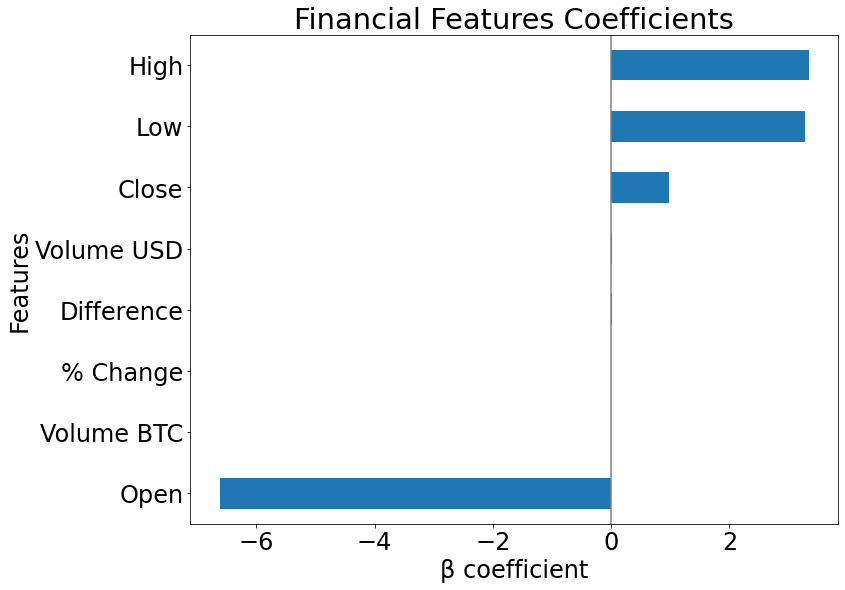

In [107]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=features.columns
).sort_values(by='Coefficients')

coefs=coefs.T.rename(columns={'sell':'Sell', 'buy':'Buy', 'volume':'Volume',
'sent_ntusd':'NTUSD Posts', 'sent_ntusd_wavg':'NTUSD Posts WA', 'sent_ntusd_coms':'NTUSD Comments', 'sent_ntusd_coms_wavg':'NTUSD Comments WA',
'sent_lr':'LR Posts', 'sent_lr_coms': 'LR Comments',
'sent_fb':'FinBERT', 'sent_fbt':'FinBERT Tone','sent_db':'DistilBERT',
'sent_dbe_sadness':'DistilBERT Sadness', 'sent_dbe_joy':'DistilBERT Joy','sent_dbe_love':'DistilBERT Love', 'sent_dbe_anger':'DistilBERT Anger', 
'sent_dbe_fear':'DistilBERT Fear', 'sent_dbe_surprise':'DistilBERT Surprise',
        'high':'High','low':'Low','close':'Close','difference':'Difference','perc':'% Change','open':'Open'}).T

plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams.update({'font.size': 24})


coefs.plot(kind='barh',legend=False)

plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


#plt.xlabel('Date')
plt.ylabel('Features')
plt.xlabel('β coefficient')
#plt.title("Sentiment Features Coefficients")
plt.title("Financial Features Coefficients")
#fig.tight_layout()
plt.savefig('financial_feature_importance.png',bbox_inches='tight')
#plt.savefig('sentiment_feature_importance.png',bbox_inches='tight')
plt.show()


In [275]:
evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn')

,knn
me,3.898352e+03
mae,5.892946e+03
mape,1.680454e-01
mse,6.519837e+07
r2_score,-1.234246e+01
rmse,8.074551e+03


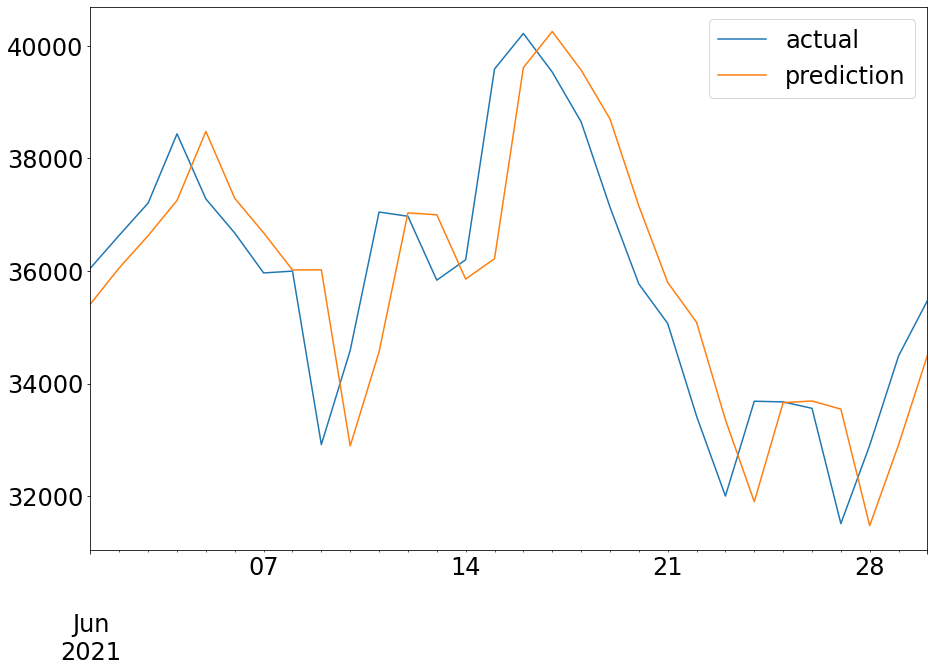

In [261]:
res_inv.plot(figsize=(15,10));

,knn
me,-0.014309
mae,2.328199
mape,8.754660
mse,0.223527
r2_score,99.712074
rmse,4.727861


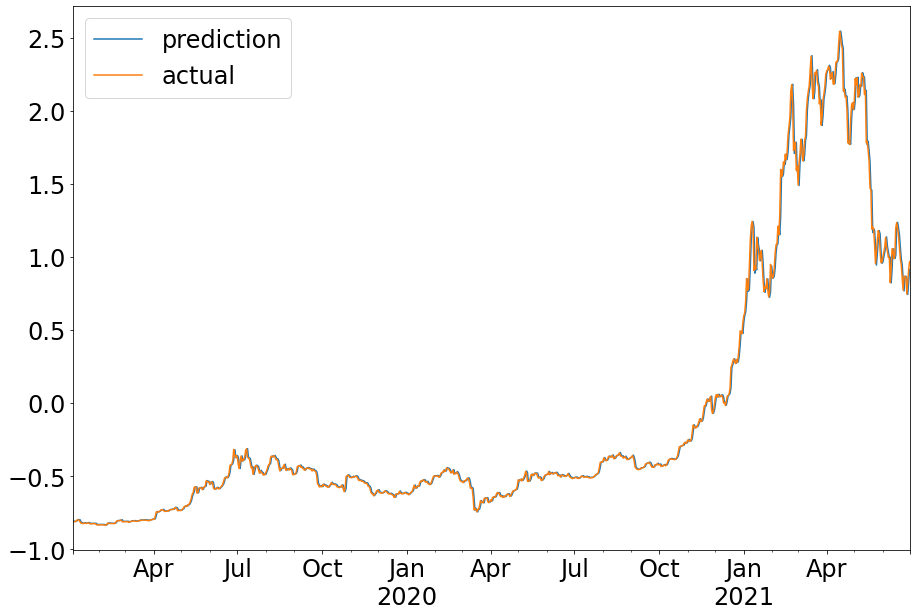

In [262]:
pred=model.predict(x)
res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        y,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)
res.plot(figsize=(15,10));
evaluate_pred(res['actual'],res['prediction'],model_name='knn')*100

,actual,prediction
2019-01-03,3823.514167,14488.435594
2019-01-04,3832.277917,13447.186609
2019-01-05,3784.328333,13885.615531
2019-01-06,3835.027083,12441.061852
2019-01-07,3864.935000,11006.677198
...,...,...
2021-06-26,33559.980833,35343.599146
2021-06-27,31512.186250,45799.328036
2021-06-28,32903.785833,34361.139122
2021-06-29,34492.129167,40312.017677


In [193]:
eval.get_granger_causality(res)

,Y_actual__X_prediction,Y_prediction__X_actual
0,0.0658,0.0
1,0.2052,0.0
2,0.3674,0.0
3,0.0503,0.0


# Loopa


In [299]:
TARGET='close'
target=dft[TARGET]
#features=dft.drop(columns=[TARGET])
res_save=[]
eval_save=[]
dt_index=dft.index
predictions=pd.DataFrame()
eval_res=pd.DataFrame()

#for col in dft.columns:
for combination in range(2):
    #for i in itertools.combinations(dft.drop(columns=[ 'high', 'low', 'Volume BTC', 'Volume USD', 'perc','difference']).columns,combination+1):
    for i in itertools.combinations(dft[sentiment_signals].columns,combination+1):
        col_name=''
        for z in i:col_name+=z+'_'

        features=dft[list(i)]

        featuresnp=features.to_numpy()
        targetnp=target.to_numpy()

        count=0
        train_window=24
        test_window=1
        test_lenght=24*7*1
        x=[]
        y=[]
        for i in range(target.shape[0]-train_window-test_window):
            x.append(featuresnp[i:train_window+i])
            y.append(targetnp[train_window+i:train_window+i+test_window])

        x=np.array(x)
        y=np.array(y)
        x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        y=y.reshape(y.shape[0],)
        xt,xv=x[:-test_lenght],x[-test_lenght:]
        yt,yv=y[:-test_lenght],y[-test_lenght:]

        # Or better yet: use a pipeline!

        model=linear_model.LinearRegression()

        model.fit(xt,yt)
        pred=model.predict(xt)
        res=pd.concat(
            [
            pd.DataFrame(
                pred,
                columns=[f'pred__{col_name}'],
                index=dt_index[-len(pred):]
                ),
            pd.DataFrame(
                yt,
                columns=['actual'],
                index=dt_index[-len(pred):]
                )
            ]
            ,axis=1)
        #res.plot(figsize=(15,10));
        predictions=pd.concat([res,predictions],axis=1)
        evl=evaluate_pred(res[f'pred__{col_name}'],res['actual'],model_name=col_name)
        eval_res=pd.concat([evl,eval_res],axis=1)

predictions=predictions.iloc[:,~predictions.columns.duplicated()]
predictions=predictions.rename(columns={'actual':f'actual_{TARGET}'})




In [303]:
#for col in dft.columns:
for combination in range(3):
    #for i in itertools.combinations(dft.drop(columns=[ 'high', 'low', 'Volume BTC', 'Volume USD', 'perc','difference']).columns,combination+1):
    for i in itertools.combinations(dft[sentiment_signals].columns,combination+1):
        col_name=''
        for z in i:col_name+=z+'_'

        print(list(i))

['volume']
['sell']
['buy']
['sent_ntusd']
['sent_ntusd_wavg']
['sent_ntusd_coms']
['sent_ntusd_coms_wavg']
['sent_lr']
['sent_lr_coms']
['sent_db']
['sent_fb']
['sent_fbt']
['sent_dbe_sadness']
['sent_dbe_joy']
['sent_dbe_love']
['sent_dbe_anger']
['sent_dbe_fear']
['sent_dbe_surprise']
['volume', 'sell']
['volume', 'buy']
['volume', 'sent_ntusd']
['volume', 'sent_ntusd_wavg']
['volume', 'sent_ntusd_coms']
['volume', 'sent_ntusd_coms_wavg']
['volume', 'sent_lr']
['volume', 'sent_lr_coms']
['volume', 'sent_db']
['volume', 'sent_fb']
['volume', 'sent_fbt']
['volume', 'sent_dbe_sadness']
['volume', 'sent_dbe_joy']
['volume', 'sent_dbe_love']
['volume', 'sent_dbe_anger']
['volume', 'sent_dbe_fear']
['volume', 'sent_dbe_surprise']
['sell', 'buy']
['sell', 'sent_ntusd']
['sell', 'sent_ntusd_wavg']
['sell', 'sent_ntusd_coms']
['sell', 'sent_ntusd_coms_wavg']
['sell', 'sent_lr']
['sell', 'sent_lr_coms']
['sell', 'sent_db']
['sell', 'sent_fb']
['sell', 'sent_fbt']
['sell', 'sent_dbe_sadness']


In [4]:
from math import factorial as fc
import pandas as pd

In [7]:
plithos=26
sample=26
fcs=[]
for i in range(sample):
    fcout=int(fc(plithos)/(fc(i+1)*fc(plithos-i-1)))
    fcs.append(fcout)
    print(i+1,':\t',fcout)
print('Synoliko: ',sum(fcs))
print('Plithos: ',plithos)
print('Xronos (min): ',sum(fcs)/38.38/60)

1 :	 26
2 :	 325
3 :	 2600
4 :	 14950
5 :	 65780
6 :	 230230
7 :	 657800
8 :	 1562275
9 :	 3124550
10 :	 5311735
11 :	 7726160
12 :	 9657700
13 :	 10400600
14 :	 9657700
15 :	 7726160
16 :	 5311735
17 :	 3124550
18 :	 1562275
19 :	 657800
20 :	 230230
21 :	 65780
22 :	 14950
23 :	 2600
24 :	 325
25 :	 26
26 :	 1
Synoliko:  67108863
Plithos:  26
Xronos (min):  29142.288952579467


In [74]:

import plotly.express as px



combdf=pd.DataFrame(fcs,columns=['Number of Combinations'])#.plot.bar()
combdf.index=combdf.index+1

fig = px.bar(combdf)


fig.update_layout(
    title="Combinations C per Number of Selected Features r",
    title_x = .5,
    title_y=.975,
    xaxis_title="<b> Date  </b>",
    yaxis_title="<b>Number of Combinations  </b>",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='  ',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=1
    )
    )
fig.add_annotation(x='21', y=9000000,
            text=f"Total Combinations: 67.108.863",
            showarrow=False,
            font = dict(size=30)
            )
fig.update_layout(showlegend=False)
fig.update_layout(

    xaxis=dict(
        title='Number of Selected Features r',
        tickmode='linear')
)
fig.show()




,mae,mape,mse,r2_score,rmse
sent_ntusd_sent_ntusd_coms_,8.178016,46.144374,1.082636,84.886672,10.404979
buy_sent_dbe_sadness_,9.023900,30.390218,1.411569,79.346472,11.880947
sent_ntusd_sent_lr_,9.509673,29.560194,1.512321,77.541224,12.297647
sell_buy_,10.362481,27.601604,1.528138,77.252917,12.361786
sent_ntusd_sent_dbe_joy_,9.638897,32.593240,1.547321,76.901402,12.439136
...,...,...,...,...,...
sent_dbe_fear_,16.744960,129.687184,4.649711,-29.288780,21.563188
sent_ntusd_wavg_,15.995726,83.779176,4.652206,-29.447986,21.568974
sent_db_,17.203890,57.278677,4.692319,-32.037858,21.661761
sent_fb_,15.478297,80.964647,4.883637,-45.240436,22.098952


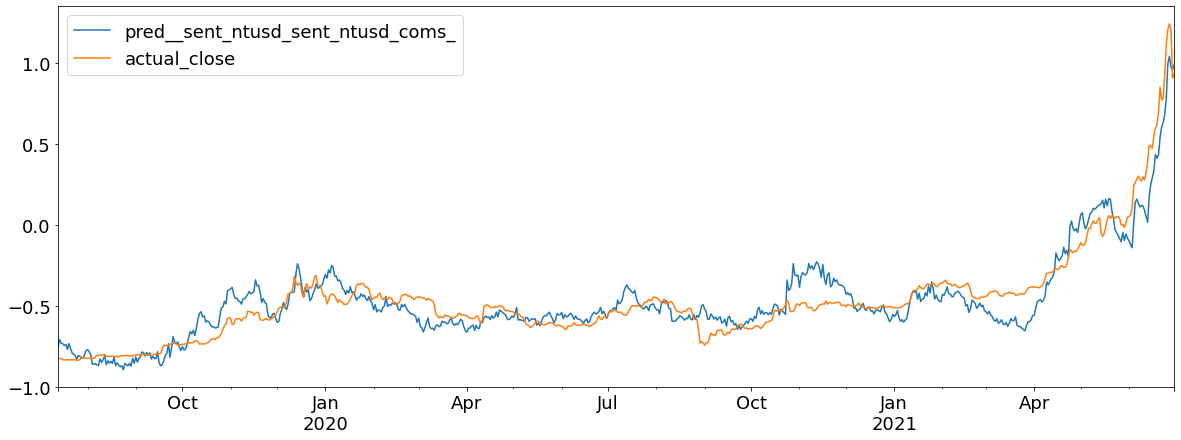

In [301]:
topcomb=pd.DataFrame(eval_res.T.sort_values(by='rmse').drop(columns=['me'])).index[0]
predictions[['pred__'+f'{topcomb}',f'actual_{TARGET}']].plot(figsize=(20,7))
pd.DataFrame(eval_res.T.sort_values(by='rmse').drop(columns=['me'])).iloc[:]*100

In [13]:
#predictions.plot(figsize=(25,35),subplots=True,layout=(10,3));
for col in predictions.columns:
    pass
    #if col!=f'actual_{TARGET}':predictions[[col,f'actual_{TARGET}']].plot(figsize=(20,7))

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_params={
    'n_neighbors':np.arange(10)+1,
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

gs=GridSearchCV(
    KNeighborsRegressor(),
    grid_params,
    verbose=True,
    cv=3,
    n_jobs=-1
)

gsres=gs.fit(xt,yt)

res=pd.concat([pd.DataFrame(gsres.predict(xv),columns=['prediction']),pd.DataFrame(yv,columns=['actual'])],axis=1)
res.plot(figsize=(15,10))
evaluate_pred(res['prediction'],res['actual'])

# LSTM

In [9]:
# univariate lstm example
from numpy import array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import BatchNormalization,LayerNormalization
from tensorflow.keras.optimizers import Adam





In [408]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scl=StandardScaler()
sclb=StandardScaler()
mmsclzo=MinMaxScaler(feature_range=(0,1))

resample_period='d' ######################
TARGET='close'   #########################

#filter df
sentiment_signals=[
'volume','sell', 'buy', 
'sent_ntusd','sent_ntusd_wavg','sent_ntusd_coms','sent_ntusd_coms_wavg', 
'sent_lr','sent_lr_coms', 
'sent_db', 'sent_fb', 'sent_fbt', 
'sent_dbe_sadness','sent_dbe_joy', 'sent_dbe_love',
'sent_dbe_anger', 'sent_dbe_fear','sent_dbe_surprise'
]

#filter on sentiment signals, topic and any other
v_topic=subs.topic2=='Bitcoin'
v_score=subs.origin!='main'

v_awards=subs.awards_value > subs.awards_value.quantile(.99)
v_awards_resample=subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90))

v_karma=subs.author_karma > subs.author_karma.quantile(.90)
v_karma_resample=subs.resample(resample_period).author_karma.transform(lambda x: x>x.quantile(.90))


aggtactic='mean'
filtered_df=subs[v_topic][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean()#### AGGREGATION TACTIC
#filtered_df=filtered_df.loc['2020-06':]##### DATE START


# & (v_score |v_awards |v_karma)
#filter on btc features
btc_fts=['unix', 'date', 'symbol', 'open','close', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD', 'avg_hl', 'avg_oc', 'perc', 'difference']
btc_filtered=btc.drop(columns=['unix','date','symbol','avg_hl','avg_oc'])



scaled__target=pd.DataFrame(sclb.fit_transform(btc_filtered[TARGET].to_numpy().reshape(-1,1)),
             index=btc_filtered[TARGET].index,
             columns=[TARGET]).resample(resample_period).mean()


tempflt=pd.DataFrame(
    scl.fit_transform(filtered_df),
    columns=filtered_df.columns,
    index=filtered_df.index)
#tempflt=tempflt.resample(resample_period).sum()


maindf=pd.concat([
    btc_filtered.drop(columns=TARGET).resample(resample_period).mean(),
    #filtered_df.resample(resample_period).mean(),
    tempflt,
    subs[v_topic].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)



dft=pd.DataFrame(
    scl.fit_transform(maindf),
    columns=maindf.columns,
    index=maindf.index).dropna()

dft=pd.concat([dft,scaled__target],axis=1).dropna()

#dft=pd.DataFrame(
#    scl.fit_transform(maindf.drop(columns=[TARGET])),
#    columns=maindf.drop(columns=[TARGET]).columns,
#    index=maindf.drop(columns=[TARGET]).index)[:'2021-06']


target=dft[TARGET]

##################################################################################
features=dft[features_list_[0]]
######################################################################
dt_index=dft.index
featuresnp=features.to_numpy()
targetnp=target.to_numpy()

count=0
train_window=5 #####################
test_window=1
test_lenght=30*1*1 #####################
x=[]
y=[]
for i in range(target.shape[0]-train_window-test_window):
    x.append(featuresnp[i:train_window+i])
    y.append(targetnp[train_window+i:train_window+i+test_window])

x=np.array(x)
y=np.array(y)

xt,xv=x[:-test_lenght],x[-test_lenght:]
yt,yv=y[:-test_lenght],y[-test_lenght:]







In [409]:
xt.shape

(875, 5, 1)

In [410]:
features_list_[1]

['open',
 'high',
 'low',
 'close',
 'Volume BTC',
 'Volume USD',
 'perc',
 'difference']

In [411]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

In [483]:
from tensorflow.keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# define model
model = Sequential()
model.add((LSTM(units=100,  input_shape=(x.shape[1], x.shape[2],),return_sequences=True)))
model.add(BatchNormalization())
model.add((LSTM(units=50,  return_sequences=False)))
#model.add((LSTM(units=50,  input_shape=(x.shape[1], x.shape[2],),return_sequences=False)))
#model.add(Bidirectional(LSTM(units=64,  input_shape=(x.shape[1],),return_sequences=True)))
#model.add((LSTM(100, return_sequences=False)))
# Add the output layer, simply one unit
model.add(Dense(
        units = 1,
        activation = 'relu'))
#model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=False)))
#model.add(Bidirectional(LSTM(64, activation='relu')))
#model.add(Dense(12))
model.add(Dense(1))

adam_opt=Adam(
    learning_rate=0.0001,
    name='Adam',
)


model.compile(optimizer='adam', loss='mse')


In [484]:
xt.shape

(875, 5, 1)

In [488]:
# History object for plotting our model loss by epoch
history = model.fit(xt, yt, epochs = 1, validation_split = 0.05, batch_size=16,callbacks = [rlrop])

#history = model.fit(xt, yt, epochs = 100,  batch_size=1)
         


Train on 831 samples, validate on 44 samples
831/831 [==============================] - 1s 613us/sample - loss: 0.0024 - val_loss: 0.0145


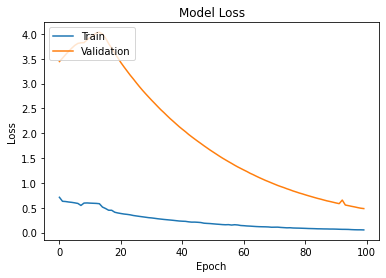

In [24]:
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

30/30 [==============================] - 0s 120us/sample


,knn
me,2.265229e+02
mae,9.737353e+02
mape,2.773205e-02
mse,1.711550e+06
r2_score,6.498433e-01
rmse,1.308262e+03


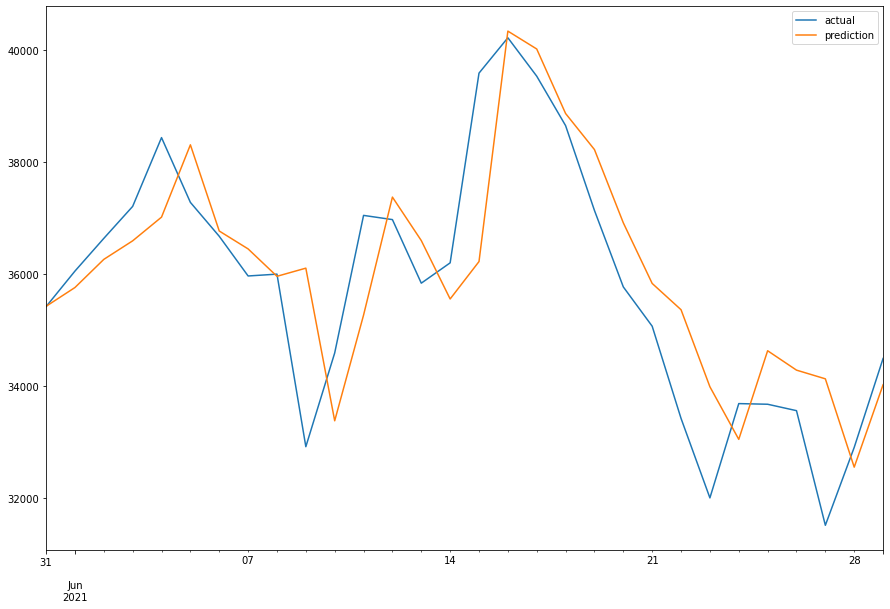

In [489]:
# demonstrate prediction
#xv = xv.reshape(xv.shape[0],xv.shape[1],1)
pred = model.predict(xv, verbose=1)

res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        yv,
        
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)


act_inv=pd.DataFrame(sclb.inverse_transform(res.actual.to_numpy().reshape(-1,1)),
            index=res.index,
            columns=['actual'])
pred_inv=pd.DataFrame(sclb.inverse_transform(res.prediction.to_numpy().reshape(-1,1)),
            index=res.index,
            columns=['prediction'])
res_inv=pd.concat([act_inv,pred_inv],axis=1)

res_inv.plot(figsize=(15,10));
evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn')
#evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn').T.to_clipboard()

In [497]:
res_inv['feature']='target only'

In [498]:
rrr=calc_returns(res_inv)

In [500]:
evaluate_pred(rrr.actual_return,rrr.prediction_return).T.to_clipboard()

In [492]:
evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn').T.to_clipboard()

875/875 [==============================] - 0s 96us/sample


,knn
me,1.837149
mae,3.205433
mape,6.620294
mse,0.438574
r2_score,99.380158
rmse,6.622496


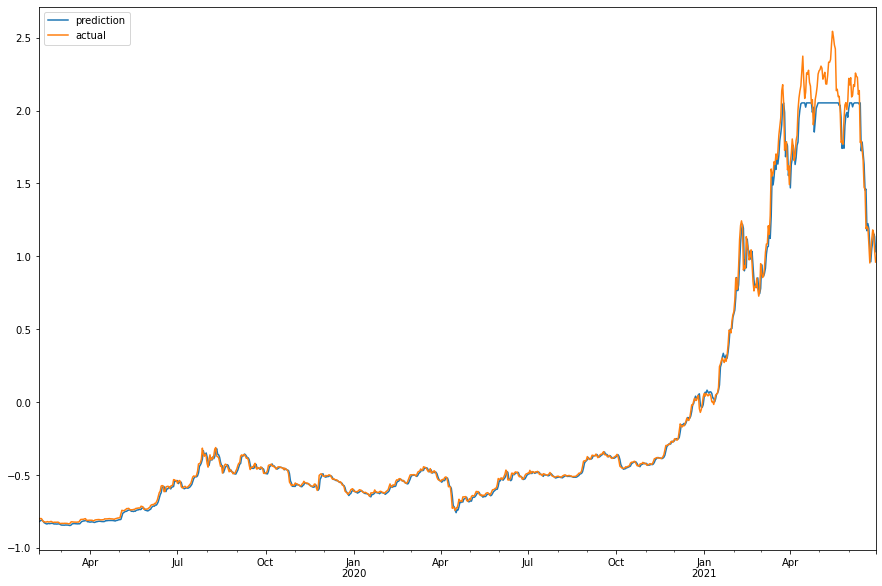

In [418]:
# demonstrate prediction
#xv = xv.reshape(xv.shape[0],xv.shape[1],1)
pred = model.predict(xt, verbose=1)

res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        yt,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)
res.plot(figsize=(15,10));
evaluate_pred(res['prediction'],res['actual'],model_name='knn')*100

In [163]:
eval.get_granger_causality(res)

,Y_actual__X_prediction,Y_prediction__X_actual
0,0.9343,0.0
1,0.0189,0.0
2,0.3016,0.0
3,0.5341,0.0


In [9]:
model.fit(xt,yt)
pred=model.predict(xv)
res=pd.concat(
    [
    pd.DataFrame(
        pred,
        columns=['prediction'],
        index=dt_index[-len(pred):]
        ),
    pd.DataFrame(
        yv,
        columns=['actual'],
        index=dt_index[-len(pred):]
        )
    ]
    ,axis=1)


act_inv=pd.DataFrame(sclb.inverse_transform(res.actual.to_numpy().reshape(-1,1)),
            index=res.index,
            columns=['actual'])
pred_inv=pd.DataFrame(sclb.inverse_transform(res.prediction.to_numpy().reshape(-1,1)),
            index=res.index,
            columns=['prediction'])
res_inv=pd.concat([act_inv,pred_inv],axis=1)


eval_res=evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='lr')
eval_res=eval_res.T.reset_index(drop=True)
eval_res['features']=None
eval_res['features']=eval_res['features'].astype('object')
eval_res.at[0, 'features'] = features.columns.values
eval_res['resample_period']=resample_period
eval_res['aggregation_method']=aggtactic
eval_res['train_window']=train_window
eval_res['test_lenght']=test_lenght
eval_res['target']=TARGET
eval_res=eval_res[['target','resample_period', 'aggregation_method', 'train_window', 'test_lenght',
       'r2_score', 'rmse','me', 'mae', 'mape', 'mse',  'features',
       ]]

#res_inv.plot(figsize=(15,10));
#evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn')

NameError: name 'xt' is not defined

In [229]:

#filter on sentiment signals, topic and any other
v_topic=subs.topic2=='Bitcoin'
v_score=subs.origin!='main'

v_awards=subs.awards_value > subs.awards_value.quantile(.99)
v_awards_resample=subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90))

v_karma=subs.author_karma > subs.author_karma.quantile(.90)
v_karma_resample=subs.resample(resample_period).author_karma.transform(lambda x: x>x.quantile(.90))

filtered_df=subs[v_topic&(subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90)))][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean()#.dropna(axis=1)#### AGGREGATION TACTIC

# & (v_score |v_awards |v_karma)
#filter on btc features


btc_fts=['unix', 'date', 'symbol', 'open','close', 'high', 'low', 'close', 'Volume BTC',
    'Volume USD', 'avg_hl', 'avg_oc', 'perc', 'difference']
btc_filtered=btc.drop(columns=['unix','date','symbol','avg_hl','avg_oc'])


btc_filtered=btc_filtered.resample(resample_period).mean()
btc_filtered['perc']=btc_filtered['close'].pct_change()
btc_filtered['difference']=btc_filtered['close'].diff()
btc_filtered=btc_filtered.dropna()
outest=btc_filtered
scaled__target=pd.DataFrame(sclb.fit_transform(btc_filtered[TARGET].to_numpy().reshape(-1,1)),
            index=btc_filtered[TARGET].index,
            columns=[TARGET]).dropna()



In [96]:
test_lenght=20
count=0
for i in range(0,x.shape[0]-test_lenght,test_lenght):
    count+=1
    xv=x[i:i+test_lenght]
    first_stage_x=x[0:i]
    last_stage_x=x[i+test_lenght:]
    xt=np.concatenate([first_stage_x,last_stage_x],axis=0)

    yv=y[i:i+test_lenght]
    first_stage_y=y[0:i]
    last_stage_y=y[i+test_lenght:]
    yt=np.concatenate([first_stage_y,last_stage_y],axis=0)

In [114]:
y.shape[0]

909

In [133]:
def model_function1(target='close',resample='d',
                  train_window=4,test_lenght=30*1*1,
                  aggtactic='mean',
                  features_list=['close','high','difference','buy','sent_lr_coms','volume']
                  ):
    from sklearn.preprocessing import StandardScaler,MinMaxScaler
    scl=StandardScaler()
    sclb=StandardScaler()
    scl1=StandardScaler()
    mmsclzo=MinMaxScaler(feature_range=(0,1))

    resample_period=resample ######################
    TARGET=target   #########################

    #filter df
    sentiment_signals=[
    'volume','sell', 'buy', 
    'sent_ntusd','sent_ntusd_wavg','sent_ntusd_coms','sent_ntusd_coms_wavg', 
    'sent_lr','sent_lr_coms', 
    'sent_db', 'sent_fb', 'sent_fbt', 
    'sent_dbe_sadness','sent_dbe_joy', 'sent_dbe_love',
    'sent_dbe_anger', 'sent_dbe_fear','sent_dbe_surprise'
    ]

    quantile_num=.80

    #filter on sentiment signals, topic and any other
    v_topic=subs.topic2=='Bitcoin'
    v_score=subs.origin!='main'

    v_awards=subs.awards_value > subs.awards_value.quantile(.99)
    v_awards_resample=subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90))

    v_karma=subs.author_karma > subs.author_karma.quantile(.90)
    v_karma_resample=subs.resample(resample_period).author_karma.transform(lambda x: x>x.quantile(.90))


    if aggtactic =='sum':
        filtered_df=subs[v_topic][sentiment_signals].drop(columns=['volume']).resample(resample_period).sum().dropna(axis=1)#### AGGREGATION TACTIC
    elif aggtactic =='mean':
        #filtered_df=subs[v_topic][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean().dropna(axis=1)#### AGGREGATION TACTIC
        filtered_df=subs[v_topic&
        (subs.resample(resample_period).num_comments.transform(lambda x: x>x.quantile(quantile_num)))
        &(subs.resample(resample_period).score.transform(lambda x: x>x.quantile(quantile_num)))][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean().dropna(axis=1)#### AGGREGATION TACTIC
    else:
        return 'Aggregation Function Name Error: sum or mean'
    # & (v_score |v_awards |v_karma)
    #filter on btc features
    #filtered_df=filtered_df.loc[:'2021-07']

    btc_fts=['unix', 'date', 'symbol', 'open','close', 'high', 'low', 'close', 'Volume BTC',
        'Volume USD', 'avg_hl', 'avg_oc', 'perc', 'difference']
    btc_filtered=btc.drop(columns=['unix','date','symbol','avg_hl','avg_oc'])


    btc_filtered=btc_filtered.resample(resample_period).mean()
    btc_filtered['perc']=btc_filtered['close'].pct_change()
    btc_filtered['difference']=btc_filtered['close'].diff()
    btc_filtered=btc_filtered.dropna()
    outest=btc_filtered
    scaled__target=pd.DataFrame(sclb.fit_transform(btc_filtered[TARGET].to_numpy().reshape(-1,1)),
                index=btc_filtered[TARGET].index,
                columns=[TARGET]).dropna()

    tempflt=pd.DataFrame(
        scl.fit_transform(filtered_df),
        columns=filtered_df.columns,
        index=filtered_df.index)
    #tempflt=tempflt.resample(resample_period).sum()


    maindf=pd.concat([
        btc_filtered.drop(columns=TARGET).resample(resample_period).mean(),
        #filtered_df.resample(resample_period).mean(),
        tempflt,
        #subs[v_topic].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)
        subs[v_topic&
        (subs.resample(resample_period).num_comments.transform(lambda x: x>x.quantile(quantile_num)))
        &(subs.resample(resample_period).score.transform(lambda x: x>x.quantile(quantile_num)))].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)



    dft=pd.DataFrame(
        scl1.fit_transform(maindf),
        columns=maindf.columns,
        index=maindf.index).dropna()

    dft=pd.concat([dft,scaled__target],axis=1).dropna()

    #dft=pd.DataFrame(
    #    scl.fit_transform(maindf.drop(columns=[TARGET])),
    #    columns=maindf.drop(columns=[TARGET]).columns,
    #    index=maindf.drop(columns=[TARGET]).index)[:'2021-06']


    target=dft[TARGET]
    
    ##################################################################################
    #features=dft.drop(columns=[TARGET])

    #features=dft.drop(columns=['open'])
    #features=dft[['open','high','low','sent_dbe_joy']]
    #features=dft[sentiment_signals]#['high','difference','buy','sent_lr_coms','volume']]
    features=dft[features_list]
    #features=dft[['sent_dbe_joy']]
    ######################################################################
    dt_index=dft.index
    featuresnp=features.to_numpy()
    targetnp=target.to_numpy()

    count=0
    train_window=train_window #####################
    test_window=1
    #test_lenght=test_lenght #####################
    x=[]
    y=[]
    for i in range(target.shape[0]-train_window-test_window):
        x.append(featuresnp[i:train_window+i])
        y.append(targetnp[train_window+i:train_window+i+test_window])

    x=np.array(x)
    y=np.array(y)
    x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
    y=y.reshape(y.shape[0],)
    #xt,xv=x[:-test_lenght],x[-test_lenght:]
    #yt,yv=y[:-test_lenght],y[-test_lenght:]


    save_res1=pd.DataFrame()
    save_res2=pd.DataFrame()
    for i in range(0,x.shape[0]-test_lenght,test_lenght):
        xv=x[i:i+test_lenght]
        first_stage_x=x[0:i]
        last_stage_x=x[i+test_lenght:]
        xt=np.concatenate([first_stage_x,last_stage_x],axis=0)

        yv=y[i:i+test_lenght]
        first_stage_y=y[0:i]
        last_stage_y=y[i+test_lenght:]
        yt=np.concatenate([first_stage_y,last_stage_y],axis=0)

        model=linear_model.BayesianRidge()



        model.fit(xt,yt)
        pred=model.predict(xv)
        res=pd.concat(
            [
            pd.DataFrame(
                pred,
                columns=['prediction'],
                index=dt_index[-len(pred):]
                ),
            pd.DataFrame(
                yv,
                columns=['actual'],
                index=dt_index[-len(pred):]
                )
            ]
            ,axis=1)


        act_inv=pd.DataFrame(sclb.inverse_transform(res.actual.to_numpy().reshape(-1,1)),
                    index=res.index,
                    columns=['actual'])
        pred_inv=pd.DataFrame(sclb.inverse_transform(res.prediction.to_numpy().reshape(-1,1)),
                    index=res.index,
                    columns=['prediction'])
        res_inv=pd.concat([act_inv,pred_inv],axis=1)


        eval_res=evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='lr')
        eval_res=eval_res.T.reset_index(drop=True)
        eval_res['features']=None
        eval_res['features']=eval_res['features'].astype('object')
        eval_res.at[0, 'features'] = features.columns.values
        eval_res['resample_period']=resample_period
        eval_res['aggregation_method']=aggtactic
        eval_res['train_window']=train_window
        eval_res['test_lenght']=test_lenght
        eval_res['target']=TARGET
        eval_res=eval_res[['target','resample_period', 'aggregation_method', 'train_window', 'test_lenght',
            'r2_score', 'rmse','me', 'mae', 'mape', 'mse',  'features',
            ]]
        count+=1
        save_res1=pd.concat([save_res1,eval_res],axis=0)
        save_res2=pd.concat([save_res2,res_inv],axis=0)
    #res_inv.plot(figsize=(15,10));

    #evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn')
    return save_res1,save_res2



# Model Function Linear Regression

In [253]:
def model_function(target='close',resample='d',
                  train_window=4,test_lenght=30*1*1,
                  aggtactic='mean',
                  features_list=['close','high','difference','buy','sent_lr_coms','volume']
                  ):
    from sklearn.preprocessing import StandardScaler,MinMaxScaler
    scl=StandardScaler()
    sclb=StandardScaler()
    scl1=StandardScaler()
    mmsclzo=MinMaxScaler(feature_range=(0,1))

    resample_period=resample ######################
    TARGET=target   #########################

    #filter df
    sentiment_signals=[
    'volume','sell', 'buy', 
    'sent_ntusd','sent_ntusd_wavg','sent_ntusd_coms','sent_ntusd_coms_wavg', 
    'sent_lr','sent_lr_coms', 
    'sent_db', 'sent_fb', 'sent_fbt', 
    'sent_dbe_sadness','sent_dbe_joy', 'sent_dbe_love',
    'sent_dbe_anger', 'sent_dbe_fear','sent_dbe_surprise'
    ]

    quantile_num=.80

    #filter on sentiment signals, topic and any other
    v_topic=subs.topic2=='Bitcoin'
    v_score=subs.origin!='main'

    v_awards=subs.awards_value > subs.awards_value.quantile(.99)
    v_awards_resample=subs.resample(resample_period).awards_value.transform(lambda x: x>x.quantile(.90))

    v_karma=subs.author_karma > subs.author_karma.quantile(.90)
    v_karma_resample=subs.resample(resample_period).author_karma.transform(lambda x: x>x.quantile(.90))


    if aggtactic =='sum':
        filtered_df=subs[v_topic][sentiment_signals].drop(columns=['volume']).resample(resample_period).sum().dropna(axis=1)#### AGGREGATION TACTIC
    elif aggtactic =='mean':
        #filtered_df=subs[v_topic][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean().dropna(axis=1)#### AGGREGATION TACTIC
        filtered_df=subs[v_topic&
        (subs.resample(resample_period).num_comments.transform(lambda x: x>x.quantile(quantile_num)))
        &(subs.resample(resample_period).score.transform(lambda x: x>x.quantile(quantile_num)))][sentiment_signals].drop(columns=['volume']).resample(resample_period).mean().dropna(axis=1)#### AGGREGATION TACTIC
    else:
        return 'Aggregation Function Name Error: sum or mean'
    # & (v_score |v_awards |v_karma)
    #filter on btc features
    #filtered_df=filtered_df.loc[:'2021-07']

    btc_fts=['unix', 'date', 'symbol', 'open','close', 'high', 'low', 'close', 'Volume BTC',
        'Volume USD', 'avg_hl', 'avg_oc', 'perc', 'difference']
    btc_filtered=btc.drop(columns=['unix','date','symbol','avg_hl','avg_oc'])


    btc_filtered=btc_filtered.resample(resample_period).mean()
    btc_filtered['perc']=btc_filtered['close'].pct_change()
    btc_filtered['difference']=btc_filtered['close'].diff()
    btc_filtered=btc_filtered.dropna()
    outest=btc_filtered
    scaled__target=pd.DataFrame(sclb.fit_transform(btc_filtered[TARGET].to_numpy().reshape(-1,1)),
                index=btc_filtered[TARGET].index,
                columns=[TARGET]).dropna()

    tempflt=pd.DataFrame(
        scl.fit_transform(filtered_df),
        columns=filtered_df.columns,
        index=filtered_df.index)
    #tempflt=tempflt.resample(resample_period).sum()


    maindf=pd.concat([
        btc_filtered.drop(columns=TARGET).resample(resample_period).mean(),
        #filtered_df.resample(resample_period).mean(),
        tempflt,
        #subs[v_topic].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)
        subs[v_topic&
        (subs.resample(resample_period).num_comments.transform(lambda x: x>x.quantile(quantile_num)))
        &(subs.resample(resample_period).score.transform(lambda x: x>x.quantile(quantile_num)))].resample(resample_period).volume.sum()],axis=1).dropna().head(-1)



    dft=pd.DataFrame(
        scl1.fit_transform(maindf),
        columns=maindf.columns,
        index=maindf.index).dropna()

    dft=pd.concat([dft,scaled__target],axis=1).dropna()

    #dft=pd.DataFrame(
    #    scl.fit_transform(maindf.drop(columns=[TARGET])),
    #    columns=maindf.drop(columns=[TARGET]).columns,
    #    index=maindf.drop(columns=[TARGET]).index)[:'2021-06']


    target=dft[TARGET]
    
    ##################################################################################
    #features=dft.drop(columns=[TARGET])

    #features=dft.drop(columns=['open'])
    #features=dft[['open','high','low','sent_dbe_joy']]
    #features=dft[sentiment_signals]#['high','difference','buy','sent_lr_coms','volume']]
    features=dft[features_list]
    #features=dft[['sent_dbe_joy']]
    ######################################################################
    dt_index=dft.index
    featuresnp=features.to_numpy()
    targetnp=target.to_numpy()

    count=0
    train_window=train_window #####################
    test_window=1
    test_lenght=test_lenght #####################
    x=[]
    y=[]
    for i in range(target.shape[0]-train_window-test_window):
        x.append(featuresnp[i:train_window+i])
        y.append(targetnp[train_window+i:train_window+i+test_window])

    x=np.array(x)
    y=np.array(y)
    x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
    y=y.reshape(y.shape[0],)
    xt,xv=x[:-test_lenght],x[-test_lenght:]
    yt,yv=y[:-test_lenght],y[-test_lenght:]

    # Or better yet: use a pipeline!


    #model=RandomForestRegressor(n_estimators=100,max_depth=30, random_state=0)
    #model=DecisionTreeRegressor()
    #model=linear_model.LinearRegression(fit_intercept=False)
    #model=KNeighborsRegressor()
    #model=linear_model.Ridge()
    #model=linear_model.OrthogonalMatchingPursuit()
    model=linear_model.BayesianRidge()
    #model=linear_model.TweedieRegressor()
    #model=linear_model.SGDRegressor()
    #model=linear_model.QuantileRegressor()


    model.fit(xt,yt)
    pred=model.predict(xv)
    res=pd.concat(
        [
        pd.DataFrame(
            pred,
            columns=['prediction'],
            index=dt_index[-len(pred):]
            ),
        pd.DataFrame(
            yv,
            columns=['actual'],
            index=dt_index[-len(pred):]
            )
        ]
        ,axis=1)


    act_inv=pd.DataFrame(sclb.inverse_transform(res.actual.to_numpy().reshape(-1,1)),
                index=res.index,
                columns=['actual'])
    pred_inv=pd.DataFrame(sclb.inverse_transform(res.prediction.to_numpy().reshape(-1,1)),
                index=res.index,
                columns=['prediction'])
    res_inv=pd.concat([act_inv,pred_inv],axis=1)


    eval_res=evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='lr')
    eval_res=eval_res.T.reset_index(drop=True)
    eval_res['features']=None
    eval_res['features']=eval_res['features'].astype('object')
    eval_res.at[0, 'features'] = features.columns.values
    eval_res['resample_period']=resample_period
    eval_res['aggregation_method']=aggtactic
    eval_res['train_window']=train_window
    eval_res['test_lenght']=test_lenght
    eval_res['target']=TARGET
    eval_res=eval_res[['target','resample_period', 'aggregation_method', 'train_window', 'test_lenght',
        'r2_score', 'rmse','me', 'mae', 'mape', 'mse',  'features',
        ]]

    #res_inv.plot(figsize=(15,10));
    
    #evaluate_pred(res_inv['actual'],res_inv['prediction'],model_name='knn')
    return eval_res,res_inv



# Model Fucntion Loopa

In [254]:
import datetime
import glob
t1df=pd.DataFrame()
def load_results():

    path = r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Predictions\ML\raw_results' # use your path
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True).drop_duplicates(subset=['target', 'resample_period', 'aggregation_method', 'train_window','test_lenght','features_string'])
    frame = frame.drop(columns=['Unnamed: 0'])
    return frame

def calc_returns(predictions_dataframe):
    actual_return=[]
    prediction_return=[]
    q=predictions_dataframe[['actual','prediction']].to_numpy()
    features_inf=predictions_dataframe['feature'][0]
    for index in range(len(q)-1):
        actual_now=q[index+1][0]
        actual_before=q[index][0]  
        prediction_now=q[index+1][1]
        #prediction_before=q[index][0]
        actual_return_ta=(actual_now-actual_before)/actual_before
        prediction_return_ta=(prediction_now-actual_before)/actual_before
        actual_return.append(actual_return_ta)
        prediction_return.append(prediction_return_ta)
    rrdf=pd.DataFrame([actual_return,prediction_return]).T
    rrdf.columns=['actual_return','prediction_return']
    rrdf['features']=features_inf
    rrdf['acutal_price']=predictions_dataframe.tail(-1)['actual'].tolist()
    rrdf['predicted_price']=predictions_dataframe.tail(-1)['prediction'].tolist()
    rrdf.index=predictions_dataframe.tail(-1).index
    return rrdf

predictive return =(prediction i - actual i-1)/actual i-1

actual return = (actual i - actual i-1)/actual i-1)

In [255]:
t1df=pd.DataFrame()
TARGET_ = 'close'
RESAMPLE_ = 'd'
TRAIN_WINDOW_ = 5
TEST__LENGHT_ = 30*7*1
#########################################
TARGET_LIST_ = ['close']
RESAMPLE_LIST_ = ['d']
AGGTACTIC_LIST_ = ['mean'] 
TRAIN_WINDOW__LIST_= 5

comb12=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt','sent_dbe_love','buy','sent_dbe_anger','sent_dbe_sadness','sent_db','sent_fb']
comb11=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt','sent_dbe_love','buy','sent_dbe_anger','sent_dbe_sadness','sent_db']
comb10=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt','sent_dbe_love','buy','sent_dbe_anger','sent_dbe_sadness']
comb9=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt','sent_dbe_love','buy','sent_dbe_anger']
comb8=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt','sent_dbe_love','buy']
comb7=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt','sent_dbe_love']
comb6=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms','sent_fbt']
comb5=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms']

all_features=dft.columns
sentiment_signals=[
    'volume','sell', 'buy', 
    'sent_ntusd','sent_ntusd_wavg','sent_ntusd_coms','sent_ntusd_coms_wavg', 
    'sent_lr','sent_lr_coms', 
    'sent_db', 'sent_fb', 'sent_fbt', 
    'sent_dbe_sadness','sent_dbe_joy', 'sent_dbe_love',
    'sent_dbe_anger', 'sent_dbe_fear','sent_dbe_surprise'
    ]
financial_signals=btc_filtered.columns

features_list_=[[TARGET_],financial_signals.tolist(),sentiment_signals,all_features.tolist(),comb12,comb11,comb10,comb9,comb8,comb7,comb6,comb5]

In [260]:
TEST__LENGHT_ = 30*3*1
prediticions_df=[]
perf_metrics=pd.DataFrame()
for target_i in TARGET_LIST_:
    for resample_i in RESAMPLE_LIST_:
        for aggtactic_i in AGGTACTIC_LIST_:
                #for combination_i in features_list_:
                        metrics,prediction_inversed=model_function(target=target_i,resample=resample_i,
                                train_window=TRAIN_WINDOW__LIST_,test_lenght=TEST__LENGHT_,
                                aggtactic=aggtactic_i,
                                features_list=comb5
                                )
                        t1df=pd.concat([t1df,metrics])
                        prediction_inversed['feature']=str(comb5)
                        prediticions_df.append(calc_returns(prediction_inversed))
                        perf_addition=calc_returns(prediction_inversed)#.head(30)

                        perf_metr_price=evaluate_pred(perf_addition.acutal_price, perf_addition.predicted_price).T
                        perf_metr_price['validated']='Price'
                        perf_metr_price['features']=str(prediction_inversed.feature[0])

                        perf_metr_return=evaluate_pred(perf_addition.actual_return, perf_addition.prediction_return).T
                        perf_metr_return['validated']='Returns'
                        perf_metr_return['features']=str(prediction_inversed.feature[0])
                        perf_metrics=pd.concat([perf_metrics,perf_metr_return,perf_metr_price])
                        
                 

perf_metrics=perf_metrics.reset_index(drop=True)
t1df['features_string']=t1df.features.apply(lambda x: '_'.join(map(str,x.tolist())))
t1df=t1df.reset_index(drop=True).drop_duplicates(subset=['target', 'resample_period', 'aggregation_method', 'train_window','test_lenght','features_string'])
#t1df=t1df.drop(columns=['features_string'])
time_now=datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')
t1df = t1df.sort_values('r2_score',ascending=False)
#t1df.to_csv(f'raw_results/result_at_{time_now}.csv')

In [261]:
perf_metrics=perf_metrics.sort_values('r2_score',ascending=False)
perf_metrics=perf_metrics[perf_metrics.validated=='Returns']

In [262]:
perf_metrics#.to_clipboard()


,me,mae,mape,mse,r2_score,rmse,validated,features
0,0.007921,0.021533,3.050257,0.000968,0.29558,0.031105,Returns,"['close', 'open', 'high', 'volume', 'sent_ntus..."


In [263]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(perf_addition[['actual_return','prediction_return']].rename(columns={'actual_return':'Actual Return','prediction_return':'Predicted Return'}).resample('d').mean())

fig.update_layout(yaxis=dict(tickformat=".0%"))

fig.update_layout(
    title="Backtesting Prediction - 3 Months",
    title_x = .09,
    xaxis_title="<b> Date  </b>",
    yaxis_title="<b> % Return  </b>",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_traces(mode='markers+lines')
fig.update_traces(marker=dict(size=12))

fig.update_layout(legend=dict(
    title=' ',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=1
    )
    )
fig.update_traces(line=dict( width=3.7))

fig.show()

In [248]:
perf_addition[['actual_return','prediction_return']].corr()

,actual_return,prediction_return
actual_return,1.000000,0.615091
prediction_return,0.615091,1.000000


In [465]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(perf_addition[['acutal_price','predicted_price']].rename(columns={'acutal_price':'Actual Price','predicted_price':'Predicted Price'}))


fig.update_layout(
    title="Daiy Price Prediction - Bayesian Ridge Regression",
    title_x = .09,
    xaxis_title="<b> Date  </b>",
    yaxis_title="<b> Bitcoin Price  </b>",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)
fig.update_traces(mode='markers+lines')
fig.update_traces(marker=dict(size=16))
fig.update_layout(legend=dict(
    title=' ',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=1
    )
    )
fig.update_traces(line=dict( width=3.7))

fig.show()

<AxesSubplot:>

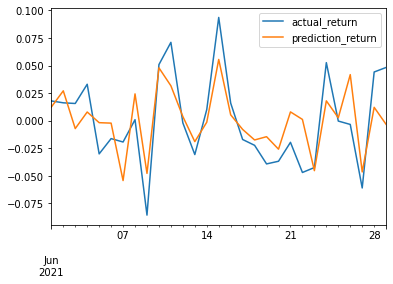

In [29]:
perf_addition[['actual_return','prediction_return']].plot()#.scatter(x='actual_return',y='prediction_return')

<AxesSubplot:>

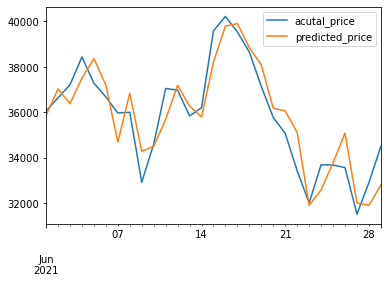

In [28]:
perf_addition[['acutal_price','predicted_price']].plot()#.scatter(x='acutal_price',y='predicted_price')

<AxesSubplot:>

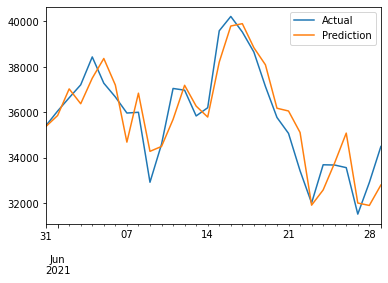

In [34]:
prediction_inversed.rename(columns={'actual':'Actual','prediction':'Prediction'}).plot()

In [864]:
eval.get_granger_causality(prediction_inversed)

,Y_prediction__X_actual,Y_actual__X_prediction
0,0.0,0.0002
1,0.0,0.0004
2,0.0,0.0000
3,0.0,0.0000


In [208]:
rf=load_results()

# LOOPA 2


In [378]:
top10__single_features=['close',
                        'high',
                        'low',
                        'open',
                        'sent_ntusd_coms',
                        'volume',
                        'Volume USD',
                        'sell',
                        'Volume BTC',
                        'sent_ntusd']
top7_double_comb=['close','open','low','high','volume','sent_ntusd_coms','sell']



In [434]:
t1df=pd.DataFrame()
TARGET_ = 'close'
RESAMPLE_ = 'd'
TRAIN_WINDOW_ = 5
TEST__LENGHT_ = 30*1*1
#########################################
TARGET_LIST_ = ['close']
RESAMPLE_LIST_ = ['d']
AGGTACTIC_LIST_ = ['mean'] 
MONTHS_LIST_ = 2
TRAIN_WINDOW__LIST_= 7
#for col in dft.columns:
for combination in range(1,2):
    #for i in itertools.combinations(dft.drop(columns=[ 'high', 'low', 'Volume BTC', 'Volume USD', 'perc','difference']).columns,combination+1):
    temp_sent_list=sentiment_signals
    a=['close' ,'open', 'high', 'volume' ,'sent_ntusd_coms', 'sent_fbt','sent_dbe_love','buy','sent_dbe_anger','sent_dbe_sadness','sent_db','sent_fb']
    for i in a:
        try:
            temp_sent_list.remove(i)
        except:
            pass
    for i in itertools.combinations(dft[sentiment_signals].columns,combination+1):
        col_name=''
        for z in i:col_name+=z+'_'
        count=0
        i=a+list(i)
        for target_i in TARGET_LIST_:
            for resample_i in RESAMPLE_LIST_:
                for aggtactic_i in AGGTACTIC_LIST_:
                    metrics,prediction_inversed=model_function(target=target_i,resample=resample_i,
                            train_window=TRAIN_WINDOW_,test_lenght=TEST__LENGHT_,
                            aggtactic=aggtactic_i,
                            features_list=list(i))
                    t1df=pd.concat([t1df,metrics])

        if combination==1:
            top5=t1df.sort_values('r2_score',ascending=False).head(5).features.tolist()

                    
t1df['features_string']=t1df.features.apply(lambda x: '_'.join(map(str,x.tolist())))
t1df=t1df.reset_index(drop=True).drop_duplicates(subset=['target', 'resample_period', 'aggregation_method', 'train_window','test_lenght','features_string'])
#t1df=t1df.drop(columns=['features_string'])
time_now=datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')
t1df = t1df.sort_values('r2_score',ascending=False)
t1df.to_csv(f'raw_results/result_at_{time_now}.csv')

In [439]:
t1df.head(10).to_clipboard()

In [424]:
temp_sent_list=sentiment_signals

In [437]:
len(all_features)

26